# Greenhouse Model

## Import dependencies and data

In [1]:
# import dependencies
import os
import pickle
import json
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from scipy.stats import wilcoxon
from scipy.optimize import minimize
from scipy.interpolate import RegularGridInterpolator

from IPython.display import clear_output

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\saved\\'
results_path = home_path + '\\model\\results\\'

In [3]:
# get merged data
data = pd.read_csv(
    data_path + 'data_processed.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

## MISC

In [4]:
def abs_humid(temp, rel_humid):
    abs_humidity =  6.112 * np.exp(17.67 * temp / (temp + 243.5)) * rel_humid * 2.1674 / (273.15 + temp)
    return abs_humidity

def rel_humid(temp, abs_humid):
    rel_humidity = abs_humid * (273.15 + temp) / (6.112 * np.exp(17.67 * temp / (temp + 243.5)) * 2.1674)
    return rel_humidity

In [5]:
ta01_min = 35
ta01_max = 75

ta02_min = 0
ta02_max = 85

## Define funcs for data engi.

In [6]:
# # reduce to one OBS per 5 MIN (take average of 10 OBS)
def data_reduce(data, m):
    idxObj = zip(
        data.index.get_level_values(0),
        data.index.get_level_values(1),
        data.index.get_level_values(2),
        data.index.get_level_values(3) // m
    )

    index = pd.MultiIndex.from_tuples(
        tuples=idxObj,
        names=['month', 'day', 'hour', 'minute']
    )

    data.index = index
    dates = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).last()[('time', 'date')]
    data = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()
    return data, dates

In [7]:
def date_flagger(data, n_steps):
    # create flag for erroneous sequences
    data['hour'] = data.index.get_level_values(2).values    
    data['date_flag'] = data.hour - data.hour.shift(n_steps) > 1
    
    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['hour'], data['date_flag']
    
    return flagged_idx

In [8]:
def seq_maker(data, targets, temps, dates, n_steps):
    
    vals = data.values
    sequences = []
    for i in range(len(vals) - n_steps):
        sequences.append(vals[i:i+n_steps])
    sequences = np.stack(sequences)
    
    flags = date_flagger(data, n_steps)
    mask = [idx not in flags for idx in range(len(sequences))]
    
    sequences = sequences[mask]
    targets = targets[n_steps:][mask].values
    
    temps_t = temps[n_steps-t_steps:-t_steps][mask].values
    temps = temps[:-n_steps][mask].values # TEMPORARY
    
    dates = dates[:-n_steps][mask].values
    
    return sequences, targets, temps, temps_t, dates

In [9]:
def data_norm(data_train, data_test):
    col_params = {}
    for col in data_train.columns:

        min_val = data_train[col].min()
        max_val = data_train[col].max()

        # normalize
        mean = data_train[col].mean()
        std = data_train[col].std()

        data_train[col] = (data_train[col] - mean) / std
        data_test[col] = (data_test[col] - mean) / std

        col_params[col] = {
            'mean':mean,
            'std':std,
            'max':max_val,
            'min':min_val
            }
    
    return data_train, data_test, col_params

## Create func for K-fold split

In [10]:
def k_fold_data(data, k_idx, k_frac, m, cols, t_steps, n_steps, shuffle):
    
    # get days
    days = data.groupby(['month', 'day'], sort=False).count().index.values
    
    # get days for K:th fold
    train_n = int(len(days)) * (1 - k_frac)
    test_n = len(days) - train_n
    
    # split days by test and train
    days_test = days[int(k_idx*test_n):int((k_idx+1)*test_n)].tolist()
    mask_test = np.array([day in days_test for day in data.index.droplevel(-1).droplevel(-1).droplevel(-1).values])
    data_train = data.loc[~mask_test].copy()
    data_test = data.loc[mask_test].copy()
    
    # reduce to m-min observations
    data_train, dates_train = data_reduce(data_train, m)
    data_test, dates_test = data_reduce(data_test, m)
    
#     # get dates
#     dates_train = data_train.time.date.values
#     dates_test = data_test.time.date.values
    
#     # remove setpoint
#     data_train[('temperatures', 'TA01_GT10X_GM10X')] -= data_train.setpoints.TA01_GT10X_GM10X + 20
#     data_test[('temperatures', 'TA01_GT10X_GM10X')] -= data_test.setpoints.TA01_GT10X_GM10X + 20
    
    # filter data
    data_train = data_train[cols].copy()
    data_test = data_test[cols].copy()
    
    # normalize
    data_train, data_test, col_params = data_norm(data_train, data_test)
    
    # get targets
    targets_train = pd.concat([data_train.pop(col) for col in [
        ('temperatures', 'TA01_GT10X_GM10X'),
        ('humidity', 'TA01_GT10X_GM10X_abs')
    ]], axis=1)

    targets_test = pd.concat([data_test.pop(col) for col in [
        ('temperatures', 'TA01_GT10X_GM10X'),
        ('humidity', 'TA01_GT10X_GM10X_abs')
    ]], axis=1)
    
    # get temp info
    temps_train = targets_train.copy()
    temps_test = targets_test.copy()
    
    # create sequences
    sequences_train, targets_train, temps_train, temps_t_train, dates_train = seq_maker(data_train, targets_train, temps_train, dates_train, n_steps)
    sequences_test, targets_test, temps_test, temps_t_test, dates_test = seq_maker(data_test, targets_test, temps_test, dates_test, n_steps)
    
    # create MASKED sequences
    sequences_masked = sequences_test.copy()
    for t in range(1, t_steps):
        sequences_masked[:, -t, :] = sequences_masked[:, -(t_steps), :]
    
    if shuffle:
        # shuffle training data randomly
        idxs = np.arange(len(targets_train))
        np.random.shuffle(idxs)

        sequences_train = sequences_train[idxs]
        targets_train = targets_train[idxs]
        temps_train = temps_train[idxs]
        temps_t_trian = temps_t_train[idxs]
        dates_train = dates_train[idxs]
    
    # return tups w. train and test
    train_tup = (sequences_train, targets_train, temps_train, temps_t_train, dates_train)
    test_tup = (sequences_test, targets_test, temps_test, temps_t_test, sequences_masked, dates_test)
    return train_tup, test_tup, col_params

## create func for grid estimation

In [11]:
def normalize(array, params):
    return (array - params['mean']) / params['std']

def normalize_inv(array, params):
    return array * params['std'] + params['mean']

In [12]:
# define func for heatmap estimations
# input seqs, temps, humids, etc., RETURN grid w. temps and humids
def grid_estimation(seq, k, temps_test, col_params, ta_lims, model):
    
    ta01_min, ta01_max, ta02_min, ta02_max = ta_lims

    temp = normalize_inv(temps_test[0], col_params[('temperatures', 'TA01_GT10X_GM10X')])
    humid = normalize_inv(temps_test[1], col_params[('humidity', 'TA01_GT10X_GM10X_abs')])
    
    ta01_minmax = np.arange(ta01_min, ta01_max, (ta01_max - ta01_min) / k) / ta01_min
    ta02_minmax = np.arange(ta02_min, ta02_max, (ta02_max - ta02_min) / k) / ta01_min

    temp_dc = -temp + normalize_inv(seq[:, 2].copy(), col_params[('temperatures', 'TA01_GT401_GM401')])
    temp_out = -temp + normalize_inv(seq[:, 4].copy(), col_params[('temperatures', 'DC_GT301_damped')])
    
    #print(temp_dc[-1], temp_out[-1])
    
    humid_dc = -humid + normalize_inv(seq[:, 5].copy(), col_params[('humidity', 'TA01_GT401_GM401_abs')])
    humid_out = -humid + normalize_inv(seq[:, 7].copy(), col_params[('humidity', 'outdoor_abs')])
    
    seqs = []

    for j in range(k):
        for i in range(k):

            seq_mod = seq.copy()

            ta01_temp = temp_dc * ta01_minmax[i]
            ta02_temp = temp_out * ta02_minmax[j]
            ta01_temp = normalize(ta01_temp, col_params[('temperatures', 'TA01_GT401_GM401_scaled')])
            ta02_temp = normalize(ta02_temp, col_params[('temperatures', 'DC_GT301_damped_scaled')])
            
            ta01_humid = humid_dc * ta01_minmax[i]
            ta02_humid = humid_out * ta02_minmax[j]
            ta01_humid = normalize(ta01_humid, col_params[('humidity', 'TA01_GT401_GM401_scaled')])
            ta02_humid = normalize(ta02_humid, col_params[('humidity', 'outdoor_scaled')])
            
            seq_mod[-t_steps:, 0] = ta01_temp[-t_steps:]
            seq_mod[-t_steps:, 1] = ta02_temp[-t_steps:]
            seq_mod[-t_steps:, 8] = ta01_humid[-t_steps:]
            seq_mod[-t_steps:, 9] = ta02_humid[-t_steps:]

            seqs.append(seq_mod)

    seqs = np.stack(seqs)
    return seqs

## Create data for specific fold

In [13]:
m = 5
t_steps = 3
n_steps = 12
k_frac = 0.05

In [14]:
# Define cols to use
cols = [
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'TA01_GT401_GM401_scaled'),
    ('temperatures', 'DC_GT301_damped_scaled'),
    ('temperatures', 'TA01_GT401_GM401'),
    ('temperatures', 'TA02_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
    ('humidity', 'TA01_GT10X_GM10X_abs'),
    ('humidity', 'TA01_GT401_GM401_abs'),
    ('humidity', 'TA02_GT401_GM401_abs'),
    ('humidity', 'outdoor_abs'),
    ('humidity', 'TA01_GT401_GM401_scaled'),
    ('humidity', 'outdoor_scaled'),
    ('sun', 'gsi'),
    ('power', 'phase'),
    ('time', 'minofday'),
    ('time', 'dayofyear')
]

### Get Autoregressive test preds for LSTM

In [15]:
k_idx = 19

In [16]:
k = 100
setpoint = 20
ta_lims = [ta01_min, ta01_max, ta02_min, ta02_max]
x0 = (k // 2, k // 2)
#x0 = (0, 0)

In [60]:
# get data
_, test_tup, col_params = k_fold_data(
    data=data, 
    k_idx=k_idx, 
    k_frac=k_frac, 
    m=m, 
    cols=cols, 
    t_steps=t_steps, 
    n_steps=n_steps,
    shuffle=True
)

# get test data
(sequences_test, targets_test, temps_test, temps_t_test, sequences_masked, dates_test) = test_tup

# load LSTM
lstm_name = 'gh_lstm_w512_v4_X'.format(k_idx)
lstm = tf.keras.models.load_model(save_path + lstm_name)

# create queue for preds
pred_queue = deque(maxlen=t_steps)
for temp in temps_t_test[:t_steps]:
    pred_queue.append(temp)

# alpha = 0.8
# ta01_smooth, ta02_smooth = 0, 0
    
# iterate over test seqs and get preds
lstm_preds = []
flow_list = []
seqs_masked = sequences_masked.copy()
for idx, seq in enumerate(seqs_masked):
    print(idx)
    
#     temps = pred_queue.popleft()
#     seqs = grid_estimation(seq, k, temps, col_params, ta_lims, lstm)
#     preds = lstm.predict([seqs, np.ones((k**2, 1)) * temps])
    seqs = grid_estimation(seq, k, temps_t_test[idx], col_params, ta_lims, lstm)
    preds = lstm.predict([seqs, np.ones((k**2, 1)) * temps_t_test[idx]])
    temp_grid = normalize(np.reshape(preds[:, 0], (k, k)), col_params[('temperatures', 'TA01_GT10X_GM10X')])#  * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean']
    #humid_grid = np.reshape(preds[:, 1], (k, k))
#     temp_grid = np.flip(temp_grid, 0)
    
    # set setpoint to TARGET
    setpoint = normalize(targets_test[idx][0], col_params[('temperatures', 'TA01_GT10X_GM10X')])
    
    # minimize objective function over temp grid
#     def ta_temp(ta_input):
#         ta01, ta02 = ta_input
#         return obj[int(ta01), int(ta02)]
    obj = RegularGridInterpolator(
        points=(np.arange(k), np.arange(k)),
        values=np.abs(temp_grid - setpoint)
    )
    
    ta_temp = RegularGridInterpolator(
        points=(np.arange(k), np.arange(k)),
        values=temp_grid
    )

    x0 += np.random.normal(loc=0, scale=1.0, size=2)
    opt = minimize(
        fun=obj, 
        x0=x0, 
        method='Nelder-Mead', 
        bounds=[(0, k-1), (0, k-1)],
        options={'disp': True}
    )
    x0 = opt.x
    
    # get idxs for flows and temps/humids
#     opt_idx = np.argmin(obj)
#     ta01, ta02 = np.unravel_index(obj.argmin(), obj.shape)
    ta01, ta02 = opt.x#.astype(int)
#     ta01_smooth = alpha * ta01_smooth + (1 - alpha) * ta01
#     ta02_smooth = alpha * ta02_smooth + (1 - alpha) * ta02
    
    ta01_temp, ta02_temp, ta01_humid, ta02_humid = seqs[int(ta02) * k + int(ta01)][-t_steps][[0, 1, 8, 9]]
#     ta01_temp, ta02_temp, ta01_humid, ta02_humid = seqs[opt_idx][-t_steps][[0, 1, 8, 9]]
    
#     # propagate new flow to sequences
#     for t in range(1, n_steps-t_steps):
#         seqs_masked[idx+t, n_steps-t_steps-t, 0] = ta01_temp
#         seqs_masked[idx+t, n_steps-t_steps-t, 1] = ta02_temp
#         seqs_masked[idx+t, n_steps-t_steps-t, 8] = ta01_humid
#         seqs_masked[idx+t, n_steps-t_steps-t, 9] = ta02_humid
        
    # add new temp and humid to queue
    opt_preds = preds[int(ta02) * k + int(ta01)]# + np.random.normal(loc=0, scale=0.1, size=2)
#     opt_preds = preds[opt_idx]
    pred_queue.append(opt_preds)
    
    # save
#     temp_list.append(opt_temp)
#     humid_list.append(opt_humid)
#     opt.pred = ta_temp(x0)
    lstm_preds.append(opt_preds)
    flow_list.append((ta01, ta02))
    
    if (idx % 100 == 0):
        save_dict = {
            'preds':lstm_preds,
            'flow':flow_list
        }

        # save autoregressive predictions
        with open(results_path + '{}_opt_flow_autoreg_init.pickle'.format(lstm_name), 'wb') as fo:
            pickle.dump(lstm_preds, fo)

0
313/313 [==============================] - 14s 43ms/step
Optimization terminated successfully.
         Current function value: 0.000870
         Iterations: 84
         Function evaluations: 162
1
313/313 [==============================] - 13s 43ms/step
Optimization terminated successfully.
         Current function value: 0.000549
         Iterations: 51
         Function evaluations: 95
2
313/313 [==============================] - 13s 43ms/step
Optimization terminated successfully.
         Current function value: 0.001355
         Iterations: 44
         Function evaluations: 81
3
313/313 [==============================] - 14s 43ms/step
Optimization terminated successfully.
         Current function value: 0.001832
         Iterations: 41
         Function evaluations: 79
4
313/313 [==============================] - 14s 44ms/step
Optimization terminated successfully.
         Current function value: 0.000082
         Iterations: 50
         Function evaluations: 96
5
313/313 [===

C:\Users\Oskar\AppData\Local\Temp\ipykernel_2232\3122596795.py:62: OptimizeWarning: Initial guess is not within the specified bounds
  opt = minimize(


313/313 [==============================] - 15s 49ms/step
Optimization terminated successfully.
         Current function value: 0.001802
         Iterations: 27
         Function evaluations: 54
16
313/313 [==============================] - 16s 51ms/step
Optimization terminated successfully.
         Current function value: 0.001428
         Iterations: 35
         Function evaluations: 63
17
313/313 [==============================] - 15s 49ms/step
Optimization terminated successfully.
         Current function value: 0.002008
         Iterations: 44
         Function evaluations: 84
18
313/313 [==============================] - 16s 51ms/step
Optimization terminated successfully.
         Current function value: 0.000095
         Iterations: 51
         Function evaluations: 97
19
313/313 [==============================] - 15s 48ms/step
Optimization terminated successfully.
         Current function value: 0.000772
         Iterations: 69
         Function evaluations: 129
20
313/313 [

313/313 [==============================] - 15s 48ms/step
Optimization terminated successfully.
         Current function value: 0.000348
         Iterations: 48
         Function evaluations: 93
58
313/313 [==============================] - 15s 49ms/step
Optimization terminated successfully.
         Current function value: 0.000352
         Iterations: 58
         Function evaluations: 112
59
313/313 [==============================] - 15s 48ms/step
Optimization terminated successfully.
         Current function value: 0.117618
         Iterations: 5
         Function evaluations: 9
60
313/313 [==============================] - 15s 49ms/step
Optimization terminated successfully.
         Current function value: 0.203272
         Iterations: 3
         Function evaluations: 5
61
313/313 [==============================] - 15s 48ms/step
Optimization terminated successfully.
         Current function value: 0.079404
         Iterations: 5
         Function evaluations: 9
62
313/313 [======

313/313 [==============================] - 12s 39ms/step
Optimization terminated successfully.
         Current function value: 0.041751
         Iterations: 5
         Function evaluations: 9
100
313/313 [==============================] - 12s 39ms/step
Optimization terminated successfully.
         Current function value: 0.192412
         Iterations: 3
         Function evaluations: 6
101
313/313 [==============================] - 12s 39ms/step
Optimization terminated successfully.
         Current function value: 0.198789
         Iterations: 3
         Function evaluations: 6
102
313/313 [==============================] - 13s 41ms/step
Optimization terminated successfully.
         Current function value: 0.036712
         Iterations: 5
         Function evaluations: 10
103
313/313 [==============================] - 13s 42ms/step
Optimization terminated successfully.
         Current function value: 0.000111
         Iterations: 43
         Function evaluations: 84
104
313/313 [===

313/313 [==============================] - 12s 39ms/step
Optimization terminated successfully.
         Current function value: 0.002678
         Iterations: 32
         Function evaluations: 62
142
313/313 [==============================] - 12s 39ms/step
Optimization terminated successfully.
         Current function value: 0.001050
         Iterations: 27
         Function evaluations: 51
143
313/313 [==============================] - 12s 39ms/step
Optimization terminated successfully.
         Current function value: 0.002180
         Iterations: 27
         Function evaluations: 53
144
313/313 [==============================] - 12s 39ms/step
Optimization terminated successfully.
         Current function value: 0.001618
         Iterations: 42
         Function evaluations: 85
145
313/313 [==============================] - 12s 39ms/step
Optimization terminated successfully.
         Current function value: 0.002308
         Iterations: 36
         Function evaluations: 71
146
313/3

313/313 [==============================] - 12s 40ms/step
Optimization terminated successfully.
         Current function value: 0.000086
         Iterations: 64
         Function evaluations: 122
224
313/313 [==============================] - 12s 40ms/step
Optimization terminated successfully.
         Current function value: 0.002098
         Iterations: 28
         Function evaluations: 55
225
313/313 [==============================] - 12s 40ms/step
Optimization terminated successfully.
         Current function value: 0.000179
         Iterations: 40
         Function evaluations: 79
226
313/313 [==============================] - 12s 40ms/step
Optimization terminated successfully.
         Current function value: 0.000058
         Iterations: 38
         Function evaluations: 76
227
313/313 [==============================] - 12s 38ms/step
Optimization terminated successfully.
         Current function value: 0.000853
         Iterations: 45
         Function evaluations: 86
228
313/

313/313 [==============================] - 12s 40ms/step
Optimization terminated successfully.
         Current function value: 0.000209
         Iterations: 34
         Function evaluations: 60
306
313/313 [==============================] - 13s 40ms/step
Optimization terminated successfully.
         Current function value: 0.067712
         Iterations: 6
         Function evaluations: 11
307
313/313 [==============================] - 13s 40ms/step
Optimization terminated successfully.
         Current function value: 0.123100
         Iterations: 1
         Function evaluations: 3
308
313/313 [==============================] - 13s 41ms/step
Optimization terminated successfully.
         Current function value: 0.099154
         Iterations: 3
         Function evaluations: 6
309
313/313 [==============================] - 13s 40ms/step
Optimization terminated successfully.
         Current function value: 0.061908
         Iterations: 3
         Function evaluations: 6
310
313/313 [===

313/313 [==============================] - 13s 42ms/step
Optimization terminated successfully.
         Current function value: 0.026647
         Iterations: 5
         Function evaluations: 10
348
313/313 [==============================] - 13s 42ms/step
Optimization terminated successfully.
         Current function value: 0.031470
         Iterations: 3
         Function evaluations: 6
349
313/313 [==============================] - 13s 42ms/step
Optimization terminated successfully.
         Current function value: 0.063357
         Iterations: 3
         Function evaluations: 6
350
313/313 [==============================] - 13s 40ms/step
Optimization terminated successfully.
         Current function value: 0.013565
         Iterations: 5
         Function evaluations: 10
351
313/313 [==============================] - 13s 40ms/step
Optimization terminated successfully.
         Current function value: 0.002714
         Iterations: 1
         Function evaluations: 3
352
313/313 [====

313/313 [==============================] - 13s 43ms/step
Optimization terminated successfully.
         Current function value: 0.070606
         Iterations: 1
         Function evaluations: 3
390
313/313 [==============================] - 13s 43ms/step
Optimization terminated successfully.
         Current function value: 0.042247
         Iterations: 5
         Function evaluations: 10
391
313/313 [==============================] - 13s 43ms/step
Optimization terminated successfully.
         Current function value: 0.080186
         Iterations: 5
         Function evaluations: 9
392
313/313 [==============================] - 13s 42ms/step
Optimization terminated successfully.
         Current function value: 0.094208
         Iterations: 5
         Function evaluations: 10
393
313/313 [==============================] - 13s 42ms/step
Optimization terminated successfully.
         Current function value: 0.091488
         Iterations: 3
         Function evaluations: 6
394
313/313 [====

Optimization terminated successfully.
         Current function value: 0.009234
         Iterations: 11
         Function evaluations: 20
431
313/313 [==============================] - 13s 42ms/step
Optimization terminated successfully.
         Current function value: 0.001719
         Iterations: 59
         Function evaluations: 115
432
313/313 [==============================] - 13s 43ms/step
Optimization terminated successfully.
         Current function value: 0.002285
         Iterations: 42
         Function evaluations: 79
433
313/313 [==============================] - 13s 43ms/step
Optimization terminated successfully.
         Current function value: 0.000499
         Iterations: 36
         Function evaluations: 67
434
313/313 [==============================] - 13s 42ms/step
Optimization terminated successfully.
         Current function value: 0.006305
         Iterations: 17
         Function evaluations: 32
435
313/313 [==============================] - 13s 43ms/step
Opti

C:\Users\Oskar\AppData\Local\Temp\ipykernel_2232\3122596795.py:62: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt = minimize(


468
313/313 [==============================] - 14s 43ms/step
Optimization terminated successfully.
         Current function value: 0.031335
         Iterations: 65
         Function evaluations: 126
469
313/313 [==============================] - 14s 43ms/step
Optimization terminated successfully.
         Current function value: 0.044153
         Iterations: 100
         Function evaluations: 191
470
313/313 [==============================] - 13s 43ms/step
471
313/313 [==============================] - 14s 44ms/step
Optimization terminated successfully.
         Current function value: 0.047918
         Iterations: 78
         Function evaluations: 144
472
313/313 [==============================] - 14s 46ms/step
Optimization terminated successfully.
         Current function value: 0.058670
         Iterations: 53
         Function evaluations: 99
473
313/313 [==============================] - 14s 46ms/step
Optimization terminated successfully.
         Current function value: 0.09715


KeyboardInterrupt



In [78]:
# save autoregressive predictions>
with open(results_path + '{}_opt_flow_autoreg_dict_init.pickle'.format(lstm_name), 'wb') as fo:
    pickle.dump(save_dict, fo)

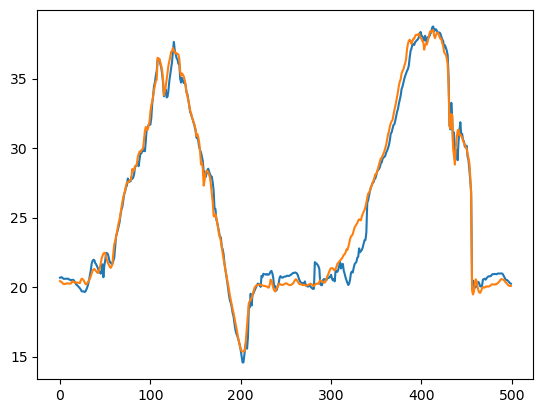

In [61]:
plt.plot([pred[0] * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean'] for pred in lstm_preds[:500]])
plt.plot(targets_test[:500, 0] * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean'])

In [54]:
np.min(preds[:, 0])

-4.9612684

In [94]:
ta_temp(x0)

array([0.15906247])

In [91]:
preds[(ta01+1) * k + ta02+1]

array([-0.45495844,  2.0509543 ], dtype=float32)

In [79]:
lstm_preds[1][0] * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean']

20.163343287173042

In [66]:
preds[ta02 * k + ta01]

array([-0.4615296,  2.0692434], dtype=float32)

In [80]:
prev_max, prev_min = 99, 0
prev_range = 99 - 0
ta01_range = ta01_max - ta01_min
ta02_range = ta02_max - ta02_min

In [81]:
# rescale TA01 flow
ta01_flow = ((np.array([flow[0] for flow in flow_list[:n]]) - prev_min) * ta01_range / prev_range) + ta01_min
ta02_flow = ((np.array([flow[1] for flow in flow_list[:n]]) - prev_min) * ta02_range / prev_range) + ta02_min

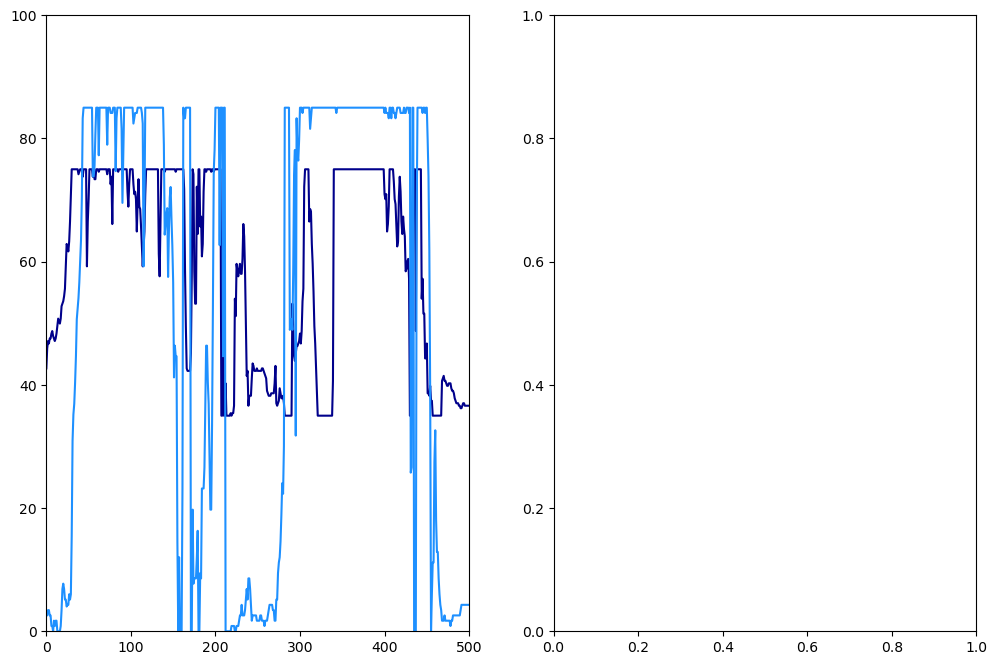

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 8)

n = 500

ax1.plot(ta01_flow, color='darkblue')
ax1.plot(ta02_flow, color='dodgerblue')
ax1.set_xlim(0, n)
ax1.set_ylim(0, 100)




plt.show()